In [20]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from xml.etree import ElementTree
import xmltodict
from re import search
import datetime
import scipy.stats as stats


In [2]:
#Create a function takes a url and returns a DataFrame of tournament names and links
def get_link_df(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    a_tags = soup.find_all('a', href = True)
    links_mixed = [link.get('href') for link in a_tags]
    links_fixed = []   
    for link in links_mixed:
        if ('http' in link) == True:
            links_fixed.append(link)
        else:
            links_fixed.append('https://www.pdga.com{}'.format(link))
    names = [name.get_text() for name in a_tags]
    links_df = pd.DataFrame()
    links_df['name'] = names
    links_df['link'] = links_fixed
    event_links_df = links_df[links_df['link'].str.contains("tour/event/")].reset_index(drop=True)
    return event_links_df

In [3]:
#Build a list of urls to iterate over
url_lst = ['https://www.pdga.com/tour/search?date_filter[min][date]=1990-01-01&date_filter[max][date]=2022-11-30&Tier[0]=M&Tier[1]=NT&Classification[0]=Pro&Classification[1]=Pro-Am']
for x in range(1,14):
    url_lst.append('https://www.pdga.com/tour/search?date_filter[min][date]=1990-01-01&date_filter[max][date]=2022-11-30&Tier[0]=M&Tier[1]=NT&Classification[0]=Pro&Classification[1]=Pro-Am&page={}'.format(x))

In [4]:
#Pass each url into get_link_df() and append the result to an empty DataFrame
#event_links_df = pd.DataFrame()
#for url in url_lst:
#    event_links_df = event_links_df.append(get_link_df(url))
event_links_df = pd.read_csv('event_links.csv')
event_links_df

,Unnamed: 0,name,link
0,0,Las Vegas Challenge,https://www.pdga.com/tour/event/47877
1,1,Waco Annual Charity Open,https://www.pdga.com/tour/event/48685
2,2,Jonesboro Open,https://www.pdga.com/tour/event/48567
3,3,OTB Open,https://www.pdga.com/tour/event/48172
4,4,The Preserve Championship,https://www.pdga.com/tour/event/48687
...,...,...,...
328,328,2022 PDGA Professional Disc Golf World Champio...,https://www.pdga.com/tour/event/55460
329,329,2022 PDGA Tim Selinske U.S. Masters Championships,https://www.pdga.com/tour/event/55565
330,330,DGPT - Discraft's Green Mountain Championship,https://www.pdga.com/tour/event/55593
331,331,DGPT - MVP Open at Maple Hill,https://www.pdga.com/tour/event/55594


In [5]:
#Create a function that takes a url and returns a DataFrame of individual tournament rounds
event_links = event_links_df['link'].astype('string')
names = event_links_df['name']

def get_event_df(url):
    
    #Request HTML from URL and use BeautifulSoup to pull out the tournament results
    r = requests.get(url)
    df = pd.read_html(r.text)[1]
    soup = BeautifulSoup(r.text, 'lxml')
    name = soup.find('h1').text
    date = soup.find('li', 'tournament-date').text.split(':')[1].strip()
    location = soup.find('li', 'tournament-location').text.split(':')[1].strip()
    director = soup.find('li', 'tournament-director').text.split(':')[1].strip()
    df['Event'] = [name] * len(df)
    df['Date Range'] = [date] * len(df)
    df['Location'] = [location] * len(df)
    df['Director'] = [director] * len(df)
    df = df.rename(columns={'Rating': 'Player Rating', 'Unnamed: 7': 'Rd1 Rating', 'Unnamed: 9': 'Rd2 Rating', 'Unnamed: 11': 'Rd3 Rating', 'Unnamed: 13': 'Finals Rating'})
    events_long = df
    
    #Transform the DataFrame from wide form to long form

    #Change the round score and rating into strings and concat them so they'll stay together when I melt the df 
    events_long = events_long.fillna('Cut')
    try:
        events_long['Rd1'] = events_long['Rd1'].astype('string')
    except:
        events_long['Rd1'] = 'Not Found'
    try:
        events_long['Rd2'] = events_long['Rd2'].astype('string')
    except:
        events_long['Rd2'] = 'Not Found'
    try:
        events_long['Rd3'] = events_long['Rd3'].astype('string')
    except:
        events_long['Rd3'] = 'Not Found'
    try:
        events_long['Finals'] = events_long['Finals'].astype('string')
    except:
        events_long['Finals'] = 'N/A'
    try:
        events_long['Rd1 Rating'] = events_long['Rd1 Rating'].astype('string')
    except:
        events_long['Rd1 Rating'] = 'Not Found'
    try:
        events_long['Rd2 Rating'] = events_long['Rd2 Rating'].astype('string')
    except:
        events_long['Rd2 Rating'] = 'Not Found'
    try:
        events_long['Rd3 Rating'] = events_long['Rd3 Rating'].astype('string')
    except:
        events_long['Rd3 Rating'] = 'Not Found'
    try:
        events_long['Finals Rating'] = events_long['Finals Rating'].astype('string')
    except:
        events_long['Finals Rating'] = 'N/A'
    events_long['Rd1_combined'] = events_long[['Rd1', 'Rd1 Rating']].agg('-'.join, axis=1)
    events_long['Rd2_combined'] = events_long[['Rd2', 'Rd2 Rating']].agg('-'.join, axis=1)
    events_long['Rd3_combined'] = events_long[['Rd3', 'Rd3 Rating']].agg('-'.join, axis=1)
    events_long['Finals_combined'] = events_long[['Finals', 'Finals Rating']].agg('-'.join, axis=1)

    #Melt the df down and split the score and rating back into separate columns
    cols =['Name', 'PDGA#', 'Player Rating', 'Event', 'Date Range', 'Location', 'Director']
    vars =['Rd1_combined', 'Rd2_combined', 'Rd3_combined', 'Finals_combined']
    events = pd.melt(events_long, id_vars=cols, value_vars=vars, var_name='combined_cols', value_name='combined_values')
    events['Round'] = [x.split('_')[0] for x in events['combined_cols'].values]
    events['Throws'] = [x.split('-')[0] for x in events['combined_values'].values]
    events['Round Rating'] = [x.split('-')[1] for x in events['combined_values'].values]
    events = events[['Name', 'PDGA#', 'Player Rating', 'Round', 'Throws', 'Round Rating', 'Event', 'Date Range', 'Location', 'Director']]

    #Remove the 'N/A' rounds
    events = events[events['Throws'] != 'N/A']
    
    #Create a column for the date of each individual round
    events['First Day'] = [x.split('to')[0].strip() for x in events['Date Range'].values]
    events['Last Day'] = [x.split('to')[1] for x in events['Date Range'].values]
    events['Year'] = [x.split('-')[2] for x in events['Last Day'].values]
    events['First Day'] = events['First Day'].astype('string') + '-' + events['Year'].astype('string')
    events['First Day'] = pd.to_datetime(events['First Day'])
    events['Last Day'] = pd.to_datetime(events['Last Day'])
    events['Event Length'] = events['Last Day'] - events['First Day']
    events['# of days not split'] = events['Event Length'].astype('string')
    events['# of days less one'] = [int(x.split(' ')[0]) for x in events['# of days not split'].values]
    events['# of days'] = events['# of days less one'] + 1
    events.loc[events['Round'] == 'Rd1', 'Round'] = '1'
    events.loc[events['Round'] == 'Rd2', 'Round'] = '2'
    events.loc[events['Round'] == 'Rd3', 'Round'] = '3'
    events.loc[events['Round'] == 'Finals', 'Round'] = '4'
    date_lst = []
    def get_date_lst(day,num):
        lst = [day + datetime.timedelta(days=idx) for idx in range(num)]
        return lst
    for day,num in events[['First Day', '# of days']].itertuples(index=False):
        date_lst.append(get_date_lst(day,num))
    events['date_lst'] = date_lst
    dates = []
    def get_date(lst,index):
        return lst[int(index) - 1]
    for lst, index in events[['date_lst', 'Round']].itertuples(index=False):
        dates.append(get_date(lst,index))
    events['Date'] = dates
    events = events[['Name', 'PDGA#', 'Player Rating', 'Round', 'Throws', 'Round Rating', 'Date', 'Event', 'Location', 'Director']]
    return events  

In [6]:
# Pass each tournament url into get_event_df() and append the results to an empty DataFrame
events= pd.DataFrame()
for url in event_links[:1]:
    events = events.append(get_event_df(url))
events

,Name,PDGA#,Player Rating,Round,Throws,Round Rating,Date,Event,Location,Director
0,Eagle Wynne McMahon,37817,1050,1,48,1071,2021-02-25,DGPT - Las Vegas Challenge presented by Innova,"Henderson, Nevada, United States",Jeff Jacquart
1,Calvin Heimburg,45971,1051,1,47,1080,2021-02-25,DGPT - Las Vegas Challenge presented by Innova,"Henderson, Nevada, United States",Jeff Jacquart
2,Ezra Aderhold,121715,1016,1,49,1063,2021-02-25,DGPT - Las Vegas Challenge presented by Innova,"Henderson, Nevada, United States",Jeff Jacquart
3,Garrett Gurthie,13864,1035,1,49,1063,2021-02-25,DGPT - Las Vegas Challenge presented by Innova,"Henderson, Nevada, United States",Jeff Jacquart
4,Richard Wysocki,38008,1054,1,49,1063,2021-02-25,DGPT - Las Vegas Challenge presented by Innova,"Henderson, Nevada, United States",Jeff Jacquart
...,...,...,...,...,...,...,...,...,...,...
539,Wyatt Merritt,51603,963,4,Cut,Cut,2021-02-28,DGPT - Las Vegas Challenge presented by Innova,"Henderson, Nevada, United States",Jeff Jacquart
540,Chris Bates,35265,964,4,Cut,Cut,2021-02-28,DGPT - Las Vegas Challenge presented by Innova,"Henderson, Nevada, United States",Jeff Jacquart
541,Tristan Lucerne,77246,976,4,Cut,Cut,2021-02-28,DGPT - Las Vegas Challenge presented by Innova,"Henderson, Nevada, United States",Jeff Jacquart
542,Noah Meintsma,56555,1018,4,Cut,Cut,2021-02-28,DGPT - Las Vegas Challenge presented by Innova,"Henderson, Nevada, United States",Jeff Jacquart


#Transform the df from wide form to long form 
#events.to_csv('events.csv')
cols =['Name', 'PDGA#', 'Player Rating', 'Event', 'Date Range', 'Location', 'Director']
vars =['Rd1_combined', 'Rd2_combined', 'Rd3_combined', 'Finals_combined']

#Change the round score and rating into strings and concat them
events_long = events_long.fillna('Cut')
events_long['Rd1'] = events_long['Rd1'].astype('string')
events_long['Rd2'] = events_long['Rd2'].astype('string')
events_long['Rd3'] = events_long['Rd3'].astype('string')
events_long['Finals'] = events_long['Finals'].astype('string')
events_long['Rd1 Rating'] = events_long['Rd1 Rating'].astype('string')
events_long['Rd2 Rating'] = events_long['Rd2 Rating'].astype('string')
events_long['Rd3 Rating'] = events_long['Rd3 Rating'].astype('string')
events_long['Finals Rating'] = events_long['Finals Rating'].astype('string')
events_long['Rd1_combined'] = events_long[['Rd1', 'Rd1 Rating']].agg('-'.join, axis=1)
events_long['Rd2_combined'] = events_long[['Rd2', 'Rd2 Rating']].agg('-'.join, axis=1)
events_long['Rd3_combined'] = events_long[['Rd3', 'Rd3 Rating']].agg('-'.join, axis=1)
events_long['Finals_combined'] = events_long[['Finals', 'Finals Rating']].agg('-'.join, axis=1)

#Melt the df down and split the score and rating back into separate columns
events = pd.melt(events_long, id_vars=cols, value_vars=vars, var_name='combined_cols', value_name='combined_values')
events['Round'] = [x.split('_')[0] for x in events['combined_cols'].values]
events['Throws'] = [x.split('-')[0] for x in events['combined_values'].values]
events['Round Rating'] = [x.split('-')[1] for x in events['combined_values'].values]
events = events[['Name', 'PDGA#', 'Player Rating', 'Round', 'Throws', 'Round Rating', 'Event', 'Date Range', 'Location', 'Director']]

#Create a column for the date of each individual round
events['First Day'] = [x.split('to')[0].strip() for x in events['Date Range'].values]
events['Last Day'] = [x.split('to')[1] for x in events['Date Range'].values]
events['Year'] = [x.split('-')[2] for x in events['Last Day'].values]
events['First Day'] = events['First Day'].astype('string') + '-' + events['Year'].astype('string')
events['First Day'] = pd.to_datetime(events['First Day'])
events['Last Day'] = pd.to_datetime(events['Last Day'])
events['Event Length'] = events['Last Day'] - events['First Day']
events['# of days not split'] = events['Event Length'].astype('string')
events['# of days less one'] = [int(x.split(' ')[0]) for x in events['# of days not split'].values]
events['# of days'] = events['# of days less one'] + 1
events.loc[events['Round'] == 'Rd1', 'Round'] = '1'
events.loc[events['Round'] == 'Rd2', 'Round'] = '2'
events.loc[events['Round'] == 'Rd3', 'Round'] = '3'
events.loc[events['Round'] == 'Finals', 'Round'] = '4'
date_lst = []
def get_date_lst(day,num):
    lst = [day + datetime.timedelta(days=idx) for idx in range(num)]
    return lst
for day,num in events[['First Day', '# of days']].itertuples(index=False):
    date_lst.append(get_date_lst(day,num))
events['date_lst'] = date_lst
dates = []
def get_date(lst,index):
    return lst[int(index) - 1]
for lst, index in events[['date_lst', 'Round']].itertuples(index=False):
    dates.append(get_date(lst,index))
events['Date'] = dates
events = events[['Name', 'PDGA#', 'Player Rating', 'Round', 'Throws', 'Round Rating', 'Date', 'Event', 'Location', 'Director']]
events

In [7]:
r = requests.get('https://www.pdga.com/tour/event/48687')
soup = BeautifulSoup(r.text, 'lxml')
#print(soup.prettify())

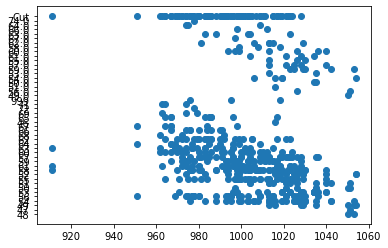

In [17]:
plt.scatter(events['Player Rating'], events['Throws'])
plt.show()

In [25]:
played_rounds = events[events['Throws'] != 'Cut']
player_rating_throws_corr, p = stats.pearsonr(played_rounds['Throws'].astype('float'), played_rounds['Player Rating'].astype('float'))
print(player_rating_throws_corr)

-0.0590287476168862
